In [2]:
using Distributions, QuadGK, LinearAlgebra, Optim, Interpolations, Plots, Printf, ForwardDiff, PrettyTables, Distributed

In [3]:
# Model parameter struct
Base.@kwdef mutable struct ModelParams
    r::Float64          # Discount rate
    δ::Float64          # Productivity shock rate
    ξ::Float64          # Exogenous destruction rate
    β::Float64          # Bargaining parameter
    c::Float64          # Vacancy cost
    A::Float64          # Matching function scale
    η::Float64          # Matching efficiency
    s::Float64          # Search intensity (employed)
    α::Float64          # CES production function weight
    ρ::Float64          # CES production function parameter
    b::Float64          # Home production parameter
    ax::Float64         # Worker Beta dist. shape1
    bx::Float64         # Worker Beta dist. shape2
    ay::Float64         # Firm Beta dist. shape1
    by::Float64         # Firm Beta dist. shape2
    σ²::Float64=0.0     # Measurement error (optional)
end

# Grid parameter struct
mutable struct GridParams
    nx::Int
    ny::Int
    x_grid::Vector{Float64}
    y_grid::Vector{Float64}
end

mutable struct State
    h::Array{Float64,2}   # Joint match distribution (nx × ny)
    S::Array{Float64,2}   # Surplus function (nx × ny)
    u::Vector{Float64}    # Unemployment by type (nx)
    v::Vector{Float64}    # Vacancy by type (ny)
    κ::Float64            # Market tightness
    V::Float64            # Number of vacancies
    N::Float64            # Number of jobs
    Pi0::Vector{Float64}  # Value function for vacancies (ny)
end

In [4]:
function trapz(x, y)
    n = length(x)
    dx = x[2] - x[1]
    return dx * (sum(y) - 0.5 * (y[1] + y[end]))
end

trapz (generic function with 1 method)

In [5]:
function make_grids(nx::Int, ny::Int)
    x_grid = collect(range(0.0, stop=1.0, length=nx))
    y_grid = collect(range(0.0, stop=1.0, length=ny))
    return GridParams(nx, ny, x_grid, y_grid)
end

make_grids (generic function with 1 method)

In [6]:
function find_best_epsilon(α, β, grid; tol=1e-10)
    beta_dist = Beta(α, β)
    ϵ_low, ϵ_high = 1e-12, 0.05
    best_ϵ = ϵ_low
    best_integral = 0.0
    # Binary search for the largest integral < 1, to the tenth digit
    for _ in 1:50
        ϵ = (ϵ_low + ϵ_high) / 2
        ℓ = x -> (x < 0 || x > 1) ? 0.0 : pdf(beta_dist, clamp(x, ϵ, 1 - ϵ))
        ℓ_vec = [ℓ(x) for x in grid]
        integral = trapz(grid, ℓ_vec)
        if integral < 1.0
            if integral > best_integral
                best_integral = integral
                best_ϵ = ϵ
            end
            ϵ_low = ϵ
        else
            ϵ_high = ϵ
        end
        if abs(1.0 - integral) < tol && integral < 1.0
            break
        end
    end
    return best_ϵ, best_integral
end


find_best_epsilon (generic function with 1 method)

In [7]:
function beta_dist(α, β; grid=nothing, tol=1e-10)
    beta_dist = Beta(α, β)
    if grid !== nothing
        ϵ, _ = find_best_epsilon(α, β, grid; tol=tol)
    else
        ϵ = 1e-2
    end
    ℓ = x -> (x < 0 || x > 1) ? 0.0 : pdf(beta_dist, clamp(x, ϵ, 1 - ϵ))
    L = x -> x < 0 ? 0.0 : (x > 1 ? 1.0 : cdf(beta_dist, x))
    return ℓ, L, ϵ
end

beta_dist (generic function with 1 method)

In [8]:
# Example parameter values (adapt as needed)
params = ModelParams(
    r = 0.05,
    δ = 0.017,
    ξ = 0.011,
    β = 0.188,
    c = 2.344,
    A = 6.96,
    η = 0.65,
    s = 0.332,
    α = 0.607,
    ρ = 0.938,
    b = 0.122,
    ax = 0.797,
    bx = 0.987,
    ay = 1.988,
    by = 0.967,
    σ² = 0.006
)

# Make 40x40 grids for x and y
grid = make_grids(40, 40)

# Example: worker beta density and CDF on grid
ℓx, Lx = beta_dist(params.ax, params.bx)
ℓy, Ly = beta_dist(params.ay, params.by)

# Evaluate densities on the grids (as vectors)
ℓx_vec = [ℓx(x) for x in grid.x_grid]
ℓy_vec = [ℓy(y) for y in grid.y_grid]


40-element Vector{Float64}:
 0.019990781882213
 0.05070913281348539
 0.10066674383809873
 0.15040312485617802
 0.20003227225214434
 0.24961035754446442
 0.2991723946887803
 0.3487433673168408
 0.39834283838444107
 0.44798723595958473
 0.4976911388579619
 0.547468076770998
 0.5973310757639121
 ⋮
 1.4211673411111565
 1.4759385093962534
 1.5315276404419738
 1.5881167498956266
 1.6459588963451386
 1.7054218530853655
 1.7670718245759685
 1.8318516096767217
 1.9015200615666972
 1.980014432430136
 2.079913318114984
 2.1795825102913886

In [9]:
function initialise_model(params::ModelParams, nx::Int, ny::Int)
    # Grids
    x_grid = collect(range(0.0, stop=1.0, length=nx))
    y_grid = collect(range(0.0, stop=1.0, length=ny))
    grid = GridParams(nx, ny, x_grid, y_grid)

    # Beta densities
    ℓx, _ = beta_dist(params.ax, params.bx)
    ℓy, _ = beta_dist(params.ay, params.by)
    ℓx_vec = [ℓx(x) for x in x_grid]
    ℓy_vec = [ℓy(y) for y in y_grid]

    # Production matrix and b(x)
    fmat = [f_xy(x, y, params) for x in x_grid, y in y_grid]
    b_vec = fill(params.b, nx)  # Adjust if b(x) is not constant

    # Joint match distribution (h) initialization
    # h is initialized as a matrix of products of densities
    h = [ℓx_vec[i] * ℓy_vec[j] for i in 1:nx, j in 1:ny]
    h ./= sum(h)  # Normalize to sum to 1
    h .*= 0.1     # Scale so that matches are a small fraction of mass

    # Initial endogenous variables (small values for h/S to avoid zeros)
    #h = fill(1e-8, nx, ny)
    S = fill(1e-8, nx, ny)
    u = fill(1e-8, nx)
    v = fill(1e-8, ny)
    κ = 0.1
    V = 1.0
    N = 1.0
    Pi0 = zeros(ny)

    # Bundle state
    state = State(h, S, u, v, κ, V, N, Pi0)

    # Return everything you might need for the solver
    return state, grid, ℓx_vec, ℓy_vec, fmat, b_vec
end


initialise_model (generic function with 1 method)

In [10]:
function f_xy(x, y, params::ModelParams)
    α, ρ, A = params.α, params.ρ, params.A
    return A * (α * x^ρ + (1 - α) * y^ρ)^(1/ρ)
end

function f_xy_grid(x_grid, y_grid, params::ModelParams)
    nx, ny = length(x_grid), length(y_grid)
    fmat = Array{Float64}(undef, nx, ny)
    for i in 1:nx
        for j in 1:ny
            fmat[i, j] = f_xy(x_grid[i], y_grid[j], params)
        end
    end
    return fmat
end

f_xy_grid (generic function with 1 method)

In [11]:
# Matching function (scalar)
function matching(U, V, params::ModelParams)
    η, s = params.η, params.s
    eff_job_seekers = U + s*(1 - U)
    return η * sqrt(eff_job_seekers * V)
end

# Market tightness: kappa = M(...) / ([U + s(1-U)] * V)
function compute_kappa(U, V, params::ModelParams)
    Mval = matching(U, V, params)
    eff_job_seekers = U + params.s*(1 - U)
    return Mval / (eff_job_seekers * V)
end

# Invert the matching function to get V for given kappa and U
function solve_V_from_kappa(kappa, U, params::ModelParams)
    η, s = params.η, params.s
    eff_job_seekers = U + s*(1 - U)
    # From: kappa = η * sqrt(eff_job_seekers * V) / (eff_job_seekers * V)
    #       = η / sqrt(eff_job_seekers * V)
    #   => sqrt(eff_job_seekers * V) = η / kappa
    #   => eff_job_seekers * V = (η / kappa)^2
    #   => V = (η / kappa)^2 / eff_job_seekers
    return (η / kappa)^2 / eff_job_seekers
end

solve_V_from_kappa (generic function with 1 method)

In [12]:
function init_endogenous_arrays(grid::GridParams)
    nx, ny = grid.nx, grid.ny
    h = zeros(nx, ny)        # Match distribution
    S = zeros(nx, ny)        # Surplus function
    u = zeros(nx)            # Unemployment distribution
    v = zeros(ny)            # Vacancy distribution
    return h, S, u, v
end

init_endogenous_arrays (generic function with 1 method)

In [13]:
fmat = f_xy_grid(grid.x_grid, grid.y_grid, params)
h, S, u, v = init_endogenous_arrays(grid)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [14]:
function update_ux(h, ℓx_vec, y_grid)
    nx, ny = size(h)
    u = zeros(nx)
    for i in 1:nx
        u[i] = ℓx_vec[i] - trapz(y_grid, h[i, :])
    end
    u .= max.(u, 0.0)
    return u
end

function compute_U(u, x_grid)
    return trapz(x_grid, u)
end

function update_vy(h, N, ℓy_vec, x_grid)
    nx, ny = size(h)
    v = zeros(ny)
    for j in 1:ny
        v[j] = N * ℓy_vec[j] - trapz(x_grid, h[:, j])
    end
    return v
end

function solve_V_from_kappa(kappa, U, params::ModelParams)
    η, s = params.η, params.s
    eff_job_seekers = U + s * (1 - U)
    return (η^2) / (kappa^2 * eff_job_seekers)
end

function update_vy(h, N, ℓy_vec, x_grid)
    # v(y) = N * ℓ(y) - ∫ h(x, y) dx
    nx, ny = size(h)
    v = zeros(ny)
    for j in 1:ny
        v[j] = N * ℓy_vec[j] - trapz(x_grid, h[:, j])
    end
    return v
end

update_vy (generic function with 1 method)

In [15]:
#integrate h(x,y) twice
function integrate_hxy(h, x_grid, y_grid)
    # Integrate h over x and y
    integral_x = [trapz(y_grid, h[i, :]) for i in 1:size(h, 1)]
    integral_xy = trapz(x_grid, integral_x)
    return integral_xy
end

integrate_hxy (generic function with 1 method)

In [16]:
function update_hxy(h, u, v, S, κ, V_total, params, grid)
    # h(x,y) update using steady-state flow equation
    nx, ny = size(h)
    δ, ξ, s = params.δ, params.ξ, params.s
    x_grid, y_grid = grid.x_grid, grid.y_grid

    h_new = zeros(nx, ny)

    for i in 1:nx
        # Precompute h(x, y') and v(y') over y'
        h_row = h[i, :]
        S_row = S[i, :]

        for j in 1:ny
            S_xy = S[i, j]

            # Find indices where S(x, y') ≥ S(x, y)
            B_mask = S_row .>= S_xy

            # Compute integrals by summing over those y' where S(x, y') ≥ S(x, y)
            h_B = trapz(y_grid, h_row .* B_mask)
            V_B = trapz(y_grid, v .* B_mask)

            numerator = δ * trapz(y_grid, h_row) + (u[i] + s * h_B) * κ * v[j]
            denominator = δ + ξ + s * κ * V_B

            h_new[i, j] = denominator > 0 && S_xy >= 0 ? numerator / denominator : 0.0
        end
    end

    # --- Normalization step ---
    total_h_mass = integrate_hxy(h_new, x_grid, y_grid)
    if total_h_mass > 1.0
        h_new .*= (1.0 / total_h_mass)
    end
    
    return h_new
end


update_hxy (generic function with 1 method)

In [17]:
function update_Sxy(S, h, u, v, κ, params, grid, ℓy_vec, fmat, b_vec)
    nx, ny = size(S)
    r, δ, ξ, β, s, c = params.r, params.δ, params.ξ, params.β, params.s, params.c
    x_grid, y_grid = grid.x_grid, grid.y_grid

    S_new = zeros(nx, ny)

    for i in 1:nx
        for j in 1:ny
            # Precompute values for this (x, y)
            S_xy = S[i, j]
            fxy = fmat[i, j]
            bx = b_vec[i]

            # --- Integrals over y' (at fixed x) ---
            # 1. ∫ S(x, y')^+ v(y') dy'
            S_x_row = S[i, :]
            int1 = trapz(y_grid, max.(S_x_row, 0.0) .* v)

            # 2. ∫ [S(x, y') - S(x, y)]^+ v(y') dy'
            diff_S_y = max.(S_x_row .- S_xy, 0.0)
            int2 = trapz(y_grid, diff_S_y .* v)

            # 3. ∫ S(x, y')^+ γ(y') dy'
            int3 = trapz(y_grid, max.(S_x_row, 0.0) .* ℓy_vec)

            # --- Integrals over x' (at fixed y) ---
            # 4. ∫ S(x, y)^+ u(x) dx
            S_y_col = S[:, j]
            int4 = trapz(x_grid, max.(S_y_col, 0.0) .* u)

            # --- Double integral over x', y' ---
            # 5. ∬ [S(x, y) - S(x, y')]^+ h(x, y') dx dy'
            # For each y', form max(S_xy - S[i, y'], 0.0), multiply by h[i, y'], then integrate over y'
            integrand = max.(S_xy .- S_x_row, 0.0) .* h[i, :]
            int5 = trapz(y_grid, integrand)  # dx comes outside: we integrate in y' at fixed x

            # Double integral over x for all i: int5 = trapz(x_grid, ...) but here just at i

            # --- Build the surplus update ---
            numer = fxy - bx + c
            numer -= κ * β * int1
            numer -= κ * (1 - β) * int4
            numer -= s * κ * (1 - β) * int5
            numer += β * s * κ * int2
            numer += δ * int3

            denom = r + δ + ξ

            S_new[i, j] = numer / denom
        end
    end
    return S_new
end


update_Sxy (generic function with 1 method)

In [18]:
function update_Pi0!(Pi0, S, h, u, κ, params, grid, ℓx_vec, ℓy_vec)
    nx, ny = size(S)
    r, δ, β, c, s = params.r, params.δ, params.β, params.c, params.s
    x_grid, y_grid = grid.x_grid, grid.y_grid

    Pi0_new = zeros(ny)
    for j in 1:ny
        # 1. ∫ S(x, y)^+ u(x) dx
        S_y_col = S[:, j]
        int1 = trapz(x_grid, max.(S_y_col, 0.0) .* u)

        # 2. ∬ [S(x, y) - S(x, y')]^+ h(x, y') dx dy'
        int2 = 0.0
        for i in 1:nx
            S_xy = S[i, j]
            # Over y' for this x
            diff = max.(S_xy .- S[i, :], 0.0) .* h[i, :]
            int2 += trapz(y_grid, diff)
        end
        int2 = int2 / nx  # (divide by nx for averaging, as needed)

        # 3. δ ∫ [Pi0(y') - Pi0(y)] γ(y') dy'
        int3 = trapz(y_grid, (Pi0 .- Pi0[j]) .* ℓy_vec)

        numer = -c + (1 - β) * κ * int1 + (1 - β) * κ * s * int2 + δ * int3
        denom = r + δ

        Pi0_new[j] = numer / denom
    end
    Pi0 .= Pi0_new  # In-place update
end


update_Pi0! (generic function with 1 method)

In [19]:
function update_kappa(S, u, h, Pi0, params, grid, ℓy_vec, y_grid, x_grid)
    β, c, δ, s = params.β, params.c, params.δ, params.s

    # Numerator
    int_Pi0 = trapz(y_grid, Pi0 .* ℓy_vec)
    numerator = c - δ * int_Pi0

    # Denominator: first y value = index 1
    S_x0 = S[:, 1]
    term1 = trapz(x_grid, max.(S_x0, 0.0) .* u)

    # Double integral: for each x, integrate over y'
    term2 = 0.0
    for i in 1:length(x_grid)
        diffs = max.(S_x0[i] .- S[i, :], 0.0) .* h[i, :]
        term2 += trapz(y_grid, diffs)
    end
    term2 *= (x_grid[2] - x_grid[1])  # dx

    denominator = term1 + s * term2

    κ_new = denominator == 0 ? 1.0 : (numerator / denominator) / (1 - β)
    #println("kappa numerator: ", numerator, ", denominator: ", denominator)
    κ_new = clamp(κ_new, 1e-8, 100.0)
    return κ_new
end

update_kappa (generic function with 1 method)

In [20]:
function solve_equilibrium!(
    state::State, params::ModelParams, grid::GridParams,
    ℓx_vec, ℓy_vec, fmat, b_vec;
    maxiter=200, tol=1e-6, pi0_iter=10, verbose=true
)
    nx, ny = grid.nx, grid.ny
    x_grid, y_grid = grid.x_grid, grid.y_grid

    for iter in 1:maxiter
        # 1. Update u(x), U
        state.u .= update_ux(state.h, ℓx_vec, y_grid)
        U = trapz(x_grid, state.u)

        # 2. Solve for V
        state.V = solve_V_from_kappa(state.κ, U, params)

        # 3. Update N, v(y)
        state.N = state.V + 1 - U
        state.v .= update_vy(state.h, state.N, ℓy_vec, x_grid)

        # 4. Update h(x,y)
        h_new = update_hxy(state.h, state.u, state.v, state.S, state.κ, state.V, params, grid)

        # 5. Update S(x,y)
        S_new = update_Sxy(state.S, state.h, state.u, state.v, state.κ, params, grid, ℓy_vec, fmat, b_vec)

        # 6. Sub-iterate Pi0
        for _ in 1:pi0_iter
            update_Pi0!(state.Pi0, S_new, h_new, state.u, state.κ, params, grid, ℓx_vec, ℓy_vec)
        end

        # 7. Update kappa
        κ_new = update_kappa(S_new, state.u, h_new, state.Pi0, params, grid, ℓy_vec, y_grid, x_grid)

        # 8. Convergence
        err = maximum(abs, h_new .- state.h) + maximum(abs, S_new .- state.S) + abs(κ_new - state.κ)
        #state.h .= h_new
        #state.S .= S_new
        #state.κ = κ_new

        state.h .= 0.95 * state.h .+ 0.05 * h_new
        state.S .= 0.95 * state.S .+ 0.05 * S_new
        state.κ = 0.95 * state.κ + 0.05 * κ_new

        if verbose && (iter % 10 == 0 || err < tol)
            println("Iter $iter: error=$(round(err, sigdigits=2)), κ=$(round(state.κ,digits=4))")
            println("h: min=$(minimum(h)), max=$(maximum(h)), sum=", trapz(x_grid, [trapz(y_grid, h[i, :]) for i in 1:nx]), ")")
            println("S: min=$(minimum(S)), max=$(maximum(S))")
            println("u: min=$(minimum(state.u)), max=$(maximum(state.u)), U=", trapz(x_grid, state.u))
        end
        if err < tol
            println("Converged after $iter iterations, error=$(round(err, sigdigits=2))")
            break
        end
    end

    return state
end

solve_equilibrium! (generic function with 1 method)

In [21]:
function compute_W0(S, v, state, params, b_vec, y_grid)
    nx, ny = size(S)
    κ, β, r = state.κ, params.β, params.r
    W0 = zeros(nx)
    for i in 1:nx
        int_val = trapz(y_grid, max.(S[i, :], 0.0) .* v)
        W0[i] = (b_vec[i] + κ * β * int_val) / r
    end
    return W0
end


compute_W0 (generic function with 1 method)

In [22]:
# Example usage
params = ModelParams(
    r = 0.05,
    δ = 0.017,
    ξ = 0.011,
    β = 0.188,
    c = 2.344,
    A = 6.96,
    η = 0.65,
    s = 0.332,
    α = 0.607,
    ρ = 0.938,
    b = 0.122,
    ax = 0.797,
    bx = 0.987,
    ay = 1.988,
    by = 0.967,
    σ² = 0.006
)

state, grid, ℓx_vec, ℓy_vec, fmat, b_vec = initialise_model(params, 40, 40)


(State([2.491593612456006e-6 6.3202406066809e-6 … 0.00025923441956457303 0.00027165690128882905; 2.058511202184159e-6 5.221672597132476e-6 … 0.00021417495774496192 0.00022443819556210436; … ; 1.0313221643614306e-6 2.61607839624458e-6 … 0.00010730249159644423 0.00011244441388848746; 1.040654392921219e-6 2.639750767854275e-6 … 0.00010827345044055364 0.0001134619009618197], [1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; … ; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], 0.1, 1.0, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), GridParams(40, 40, [0.0, 0.02564102564102564,

In [23]:
state = solve_equilibrium!(state, params, grid, ℓx_vec, ℓy_vec, fmat, b_vec;
                          maxiter=500, tol=1e-6, pi0_iter=10)

Iter 10: error=24.0, κ=0.2834
h: min=0.0, max=0.0, sum=0.0)
S: min=0.0, max=0.0
u: min=0.5199786251385528, max=1.2607547662021834, U=0.6244415851752271
Iter 20: error=9.9, κ=0.493
h: min=0.0, max=0.0, sum=0.0)
S: min=0.0, max=0.0
u: min=0.3094027978065472, max=0.7501867060534542, U=0.37156137614020146
Iter 30: error=12.0, κ=0.7457
h: min=0.0, max=0.0, sum=0.0)
S: min=0.0, max=0.0
u: min=0.18332327147219285, max=0.4444907484471279, U=0.22015265378860874
Iter 40: error=12.0, κ=1.0674
h: min=0.0, max=0.0, sum=0.0)
S: min=0.0, max=0.0
u: min=0.10783480177413707, max=0.26145928645237126, U=0.12949865879382272
Iter 50: error=12.0, κ=1.4995
h: min=0.0, max=0.0, sum=0.0)
S: min=0.0, max=0.0
u: min=0.06263706647933387, max=0.15187158911330445, U=0.07522076330091323
Iter 60: error=13.0, κ=2.1211
h: min=0.0, max=0.0, sum=0.0)
S: min=0.0, max=0.0
u: min=0.035575512788417196, max=0.08625738663033022, U=0.04272258228518799
Iter 70: error=10.0, κ=3.0227
h: min=0.0, max=0.0, sum=0.0)
S: min=0.0, max=0

State([0.06058911867134833 0.11884467193692055 … 3.9311043973394373 4.112894372330652; 0.05005768417421759 0.0981874122902359 … 3.2478099058569083 3.3980016150196897; … ; 0.025079095576792727 0.049192277627039635 … 1.627165466959253 1.7024121007393127; 0.02530603131043937 0.04963740873549043 … 1.6418893627185 1.7178168882790876], [0.5223460497497532 0.6855669398499812 … 4.357988932774724 4.388786594752348; 1.248810519937282 1.4893388293795398 … 5.701944747256913 5.739030934260711; … ; 31.576843168172626 31.989102423329157 … 39.2922834375546 39.36758873546095; 32.412640089714465 32.826338071391305 … 40.11653395049119 40.19131207738693], [0.09863418882908626, 0.0814898472533172, 0.070818215484727, 0.06524588755142924, 0.06156723187223134, 0.058862750776598194, 0.05674600676050212, 0.05501977862710916, 0.05357050262139418, 0.05232712629529224  …  0.04162746105518045, 0.04141465966874247, 0.0412200932939919, 0.04104557976909129, 0.04089440185115156, 0.040772570995526114, 0.0406919691470776

In [24]:
surface(x_grid, y_grid, state.h;
    xlabel = "x", ylabel = "y", zlabel = "h(x,y)",
    title = "Match Distribution h(x,y)")

LoadError: UndefVarError: `x_grid` not defined

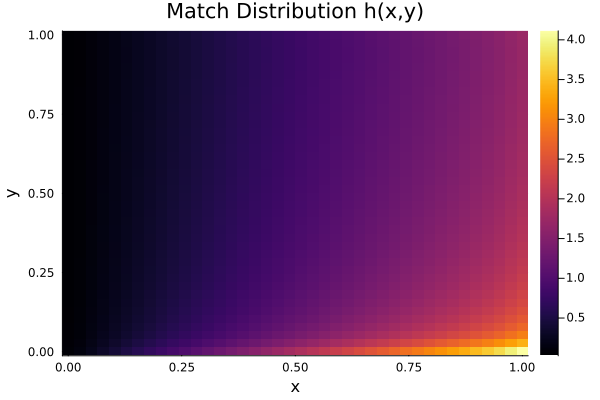

In [ ]:
heatmap(x_grid, y_grid, state.h;
    xlabel = "x", ylabel = "y", title = "Match Distribution h(x,y)",
    color=:viridis, c=:auto)

In [ ]:
int_int_h = integrate_hxy(state.h, grid.x_grid, grid.y_grid)
println("Total mass of h(x,y): ", int_int_h)

Total mass of h(x,y): 0.9453783363582764


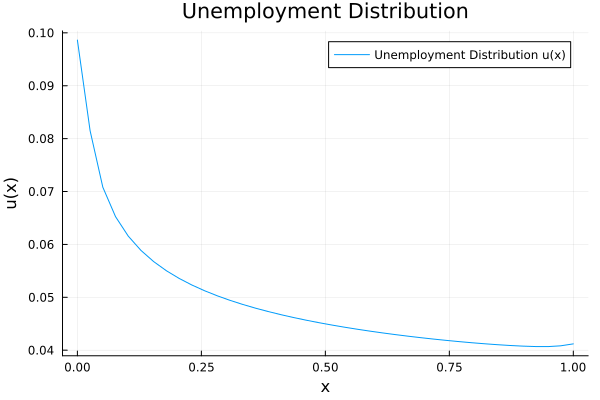

In [ ]:
# unemployment distribution
plot(grid.x_grid, state.u, label="Unemployment Distribution u(x)",
    xlabel="x", ylabel="u(x)", title="Unemployment Distribution")

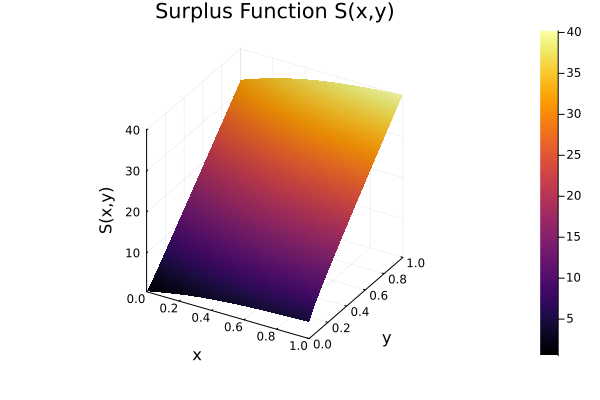

In [ ]:
surface(x_grid, y_grid, state.S;
    xlabel = "x", ylabel = "y", zlabel = "S(x,y)",
    title = "Surplus Function S(x,y)")

In [ ]:
trapz(grid.x_grid, state.u)

0.04885271184912264

In [ ]:
for _ in 1:20
    update_Pi0!(state.Pi0, state.S, state.h, state.u, state.κ, params, grid, ℓx_vec, ℓy_vec)
end
println("Updated Pi0: min = $(minimum(state.Pi0)), max = $(maximum(state.Pi0))")

Updated Pi0: min = 1.9793729052160386e-6, max = 25.2454890382543


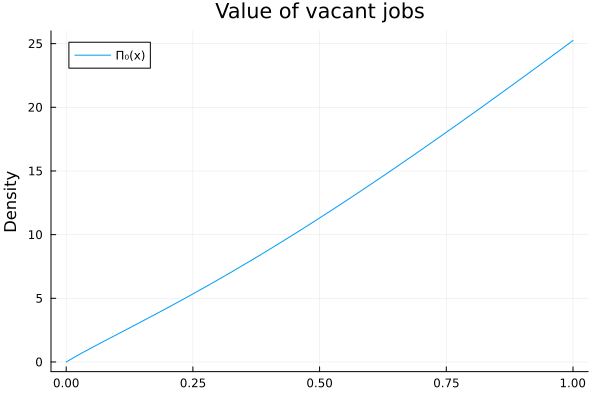

In [ ]:
Π₀ = plot(y_grid, state.Pi0, label="Π₀(x)", ylabel="Density", title= "Value of vacant jobs")
display(Π₀)

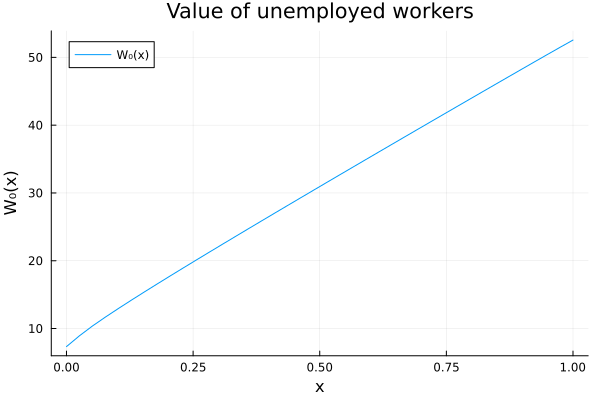

In [ ]:
W0 = compute_W0(state.S, state.v, state, params, b_vec, grid.y_grid)
W0_plot = plot(grid.x_grid, W0, label="W₀(x)",
    xlabel="x", ylabel="W₀(x)", title="Value of unemployed workers")
display(W0_plot)

## Debugging

In [ ]:
# -- Set your parameter values --
params = ModelParams(
    r = 0.05, δ = 0.017, ξ = 0.011, β = 0.188, c = 2.344, η = 0.65, s = 0.332,
    α = 0.607, ρ = 0.938, b = 0.122, ax = 0.797, bx = 0.987, ay = 1.988, by = 0.967, σ² = 0.006,
    A = 6.964 # Or your preferred A
)

# -- Set grid sizes --
nx, ny = 40, 40

# -- Initialise model and precomputes --
state, grid, ℓx_vec, ℓy_vec, fmat, b_vec = initialise_model(params, nx, ny)

x_grid, y_grid = grid.x_grid, grid.y_grid

# Optional: Print shapes and grid
println("nx = $nx, ny = $ny")
println("x_grid = ", x_grid)
println("y_grid = ", y_grid)

nx = 40, ny = 40
x_grid = [0.0, 0.02564102564102564, 0.05128205128205128, 0.07692307692307693, 0.10256410256410256, 0.1282051282051282, 0.15384615384615385, 0.1794871794871795, 0.20512820512820512, 0.23076923076923078, 0.2564102564102564, 0.28205128205128205, 0.3076923076923077, 0.3333333333333333, 0.358974358974359, 0.38461538461538464, 0.41025641025641024, 0.4358974358974359, 0.46153846153846156, 0.48717948717948717, 0.5128205128205128, 0.5384615384615384, 0.5641025641025641, 0.5897435897435898, 0.6153846153846154, 0.6410256410256411, 0.6666666666666666, 0.6923076923076923, 0.717948717948718, 0.7435897435897436, 0.7692307692307693, 0.7948717948717948, 0.8205128205128205, 0.8461538461538461, 0.8717948717948718, 0.8974358974358975, 0.9230769230769231, 0.9487179487179487, 0.9743589743589743, 1.0]
y_grid = [0.0, 0.02564102564102564, 0.05128205128205128, 0.07692307692307693, 0.10256410256410256, 0.1282051282051282, 0.15384615384615385, 0.1794871794871795, 0.20512820512820512, 0.2307692307

In [ ]:
# Print initial state arrays (sanity check)
println("Initial κ: ", state.κ)
println("Initial h min/max: ", minimum(state.h), " / ", maximum(state.h))
println("Initial S min/max: ", minimum(state.S), " / ", maximum(state.S))
println("Initial Pi0 min/max: ", minimum(state.Pi0), " / ", maximum(state.Pi0))

Initial κ: 0.1
Initial h min/max: 1.027618896029703e-6 / 0.00027165690128882905
Initial S min/max: 1.0e-8 / 1.0e-8
Initial Pi0 min/max: 0.0 / 0.0


In [ ]:
# Example usage
params = ModelParams(
    r = 0.05,
    δ = 0.017,
    ξ = 0.011,
    β = 0.188,
    c = 2.344,
    A = 6.96,
    η = 0.65,
    s = 0.332,
    α = 0.607,
    ρ = 0.938,
    b = 0.122,
    ax = 0.797,
    bx = 0.987,
    ay = 1.988,
    by = 0.967,
    σ² = 0.006
)

state, grid, ℓx_vec, ℓy_vec, fmat, b_vec = initialise_model(params, 40, 40)

(State([2.491593612456006e-6 6.3202406066809e-6 … 0.00025923441956457303 0.00027165690128882905; 2.058511202184159e-6 5.221672597132476e-6 … 0.00021417495774496192 0.00022443819556210436; … ; 1.0313221643614306e-6 2.61607839624458e-6 … 0.00010730249159644423 0.00011244441388848746; 1.040654392921219e-6 2.639750767854275e-6 … 0.00010827345044055364 0.0001134619009618197], [1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; … ; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8; 1.0e-8 1.0e-8 … 1.0e-8 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], [1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8  …  1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8, 1.0e-8], 0.1, 1.0, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), GridParams(40, 40, [0.0, 0.02564102564102564,

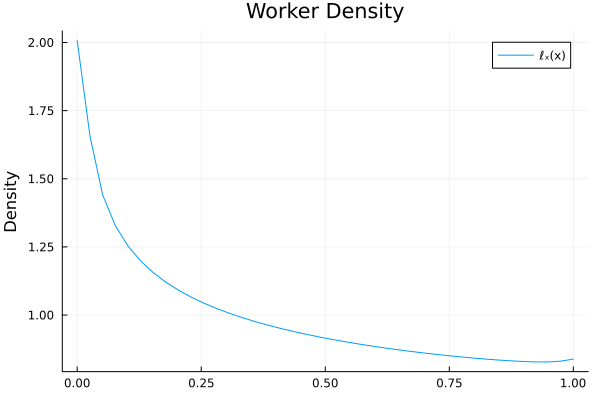

In [ ]:
ℓx_vec_plot = plot(x_grid, ℓx_vec, label="ℓₓ(x)", ylabel="Density", title="Worker Density")
display(ℓx_vec_plot)

In [ ]:
state.u .= update_ux(state.h, ℓx_vec, y_grid)
U = trapz(x_grid, state.u)

println("Updated u(x): ", state.u)
println("Total unemployment U: ", U)


Updated u(x): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total unemployment U: 0.0


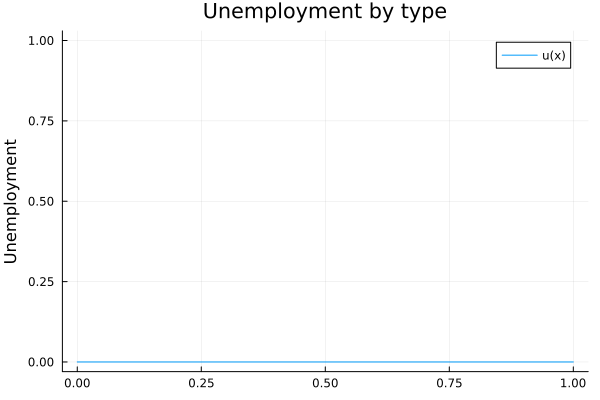

In [ ]:
u_plot = plot(x_grid, state.u, label="u(x)", ylabel="Unemployment", title="Unemployment by type")
display(u_plot)

In [ ]:
state.V = solve_V_from_kappa(state.κ, U, params)
state.N = state.V + 1 - U
state.v .= update_vy(state.h, state.N, ℓy_vec, x_grid)

println("Updated V: ", state.V)
println("Updated N: ", state.N)
println("Updated v(y): min = $(minimum(state.v)), max = $(maximum(state.v))")

Updated V: 158.30753349416193
Updated N: 159.30753349416193
Updated v(y): min = 3.1749621994181703, max = 341.9895780683156


In [ ]:
h_new = update_hxy(state.h, state.u, state.v, state.S, state.κ, state.V, params, grid)
println("Updated h: min = $(minimum(h_new)), max = $(maximum(h_new))")
state.h .= h_new


Updated h: min = 0.0, max = 0.0


40×40 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [ ]:
int_int_h = integrate_hxy(state.h, x_grid, y_grid)

0.0

In [ ]:
S_new = update_Sxy(state.S, state.h, state.u, state.v, state.κ, params, grid, ℓy_vec, fmat, b_vec)
println("Updated S: min = $(minimum(S_new)), max = $(maximum(S_new))")
state.S .= S_new

Updated S: min = -498779.7829013702, max = 82.35837231923368


40×40 Matrix{Float64}:
 28.4872  29.2853  29.4118  26.068   …       -4.98276e5       -4.9878e5
 29.8309  30.7281  30.8964  27.5795          -4.81696e5       -4.82016e5
 31.1746  32.1056  32.2969  28.9969          -4.7145e5        -4.71679e5
 32.5183  33.4713  33.6789  30.3915          -4.6619e5        -4.66378e5
 33.862   34.8314  35.0519  31.7746          -4.62764e5       -4.62928e5
 35.2058  36.1883  36.4193  33.1506  …  -460275.0             -4.60422e5
 36.5495  37.543   37.783   34.5217          -4.58348e5  -458483.0
 37.8932  38.8962  39.1441  35.8893          -4.56791e5       -4.56917e5
 39.2369  40.2483  40.5032  37.2541          -4.55496e5       -4.55615e5
 40.5806  41.5994  41.8606  38.6169          -4.54394e5       -4.54506e5
 41.9244  42.9499  43.2168  39.9779  …       -4.5344e5        -4.53548e5
 43.2681  44.2997  44.572   41.3375          -4.52603e5       -4.52706e5
 44.6118  45.6491  45.9262  42.6959          -4.5186e5        -4.5196e5
  ⋮                                 

In [ ]:
for _ in 1:20
    update_Pi0!(state.Pi0, state.S, state.h, state.u, state.κ, params, grid, ℓx_vec, ℓy_vec)
end
println("Updated Pi0: min = $(minimum(state.Pi0)), max = $(maximum(state.Pi0))")

Updated Pi0: min = -34.98507472416085, max = -34.98507445639302


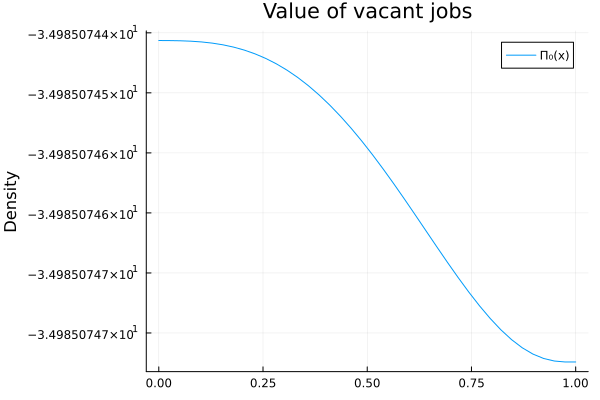

In [ ]:
Π₀ = plot(y_grid, state.Pi0, label="Π₀(x)", ylabel="Density", title= "Value of vacant jobs")
display(Π₀)

In [ ]:
κ_new = update_kappa(state.S, state.u, state.h, state.Pi0, params, grid, ℓy_vec, y_grid, x_grid)
println("Updated κ: ", κ_new)
state.κ = κ_new

Updated κ: 1.0


1.0